<a href="https://colab.research.google.com/github/mostafa-ja/Anomaly-detection/blob/main/BGL_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#upload log files
!wget 'https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/X_train_index'
!wget 'https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/Xabnorm_test_index'
!wget 'https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/Xnorm_test_index'
!wget 'https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/log2index'
!wget 'https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/index2embed'

--2023-09-08 17:34:14--  https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/X_train_index
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9341136 (8.9M) [text/plain]
Saving to: ‘X_train_index’

X_train_index       100%[===================>]   8.91M  --.-KB/s    in 0.06s   

2023-09-08 17:34:15 (148 MB/s) - ‘X_train_index’ saved [9341136/9341136]

--2023-09-08 17:34:15--  https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/Xabnorm_test_index
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response...

In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import pandas as pd
import json
from sklearn.metrics.pairwise import cosine_similarity
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:

#Json file name
with open('/content/index2embed') as f:
    embeddings = [json.loads(line) for line in f.readlines()]

print('number of logs : ', len(embeddings))
print('dimention of embedding : ',len(embeddings[0]))

number of logs :  736
dimention of embedding :  384


http://nlp.seas.harvard.edu/2018/04/03/attention.html#position-wise-feed-forward-networks

The positional encodings have the same dimension d_model as the embeddings, so that the two can be summed.

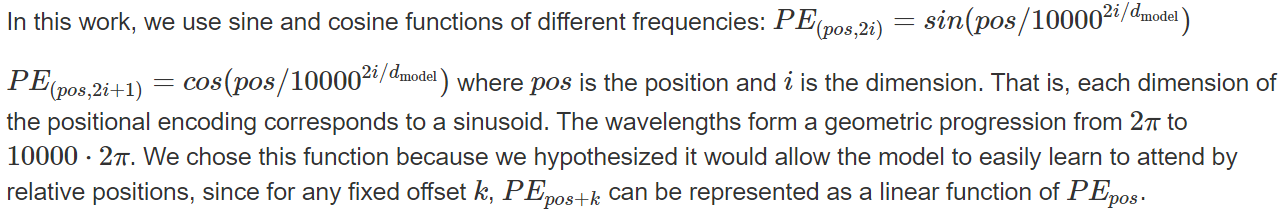

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, max_len=20, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

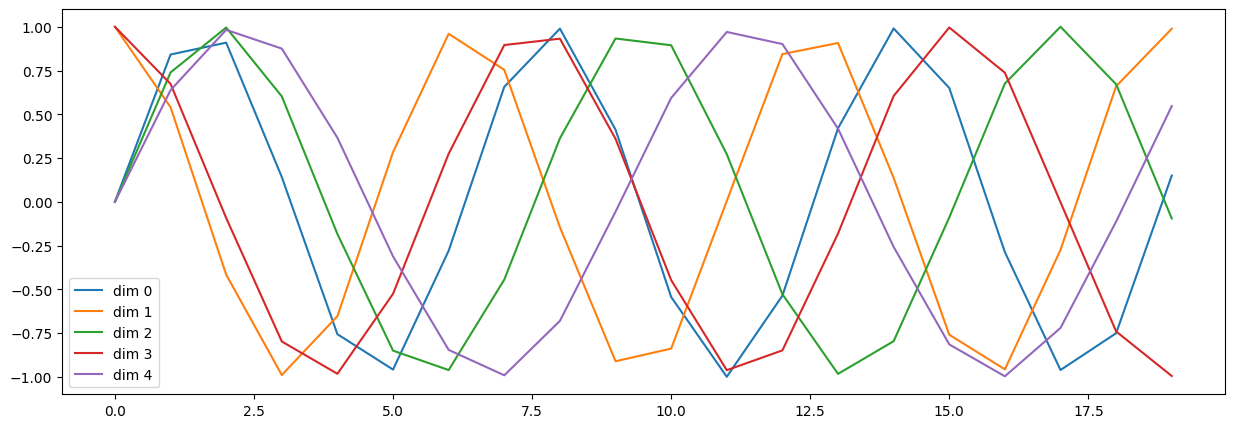

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(100)
y = pe.forward(Variable(torch.zeros(1, 20, 100))) #(batch,sequence_length,d_model(embedding dim))
plt.plot(np.arange(20), y[0, :, :5].data.numpy())
plt.legend(["dim %d"%p for p in [0,1,2,3,4]])

In [ ]:

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [ ]:
def train(model, dataloader):
    model.train()
    epochs = 500
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        for batch in dataloader:
            optim.zero_grad()
            input = batch['input_ids'].clone()
            src_mask = model.generate_square_subsequent_mask(batch['input_ids'].size(1))
            rand_value = torch.rand(batch.input_ids.shape)
            rand_mask = (rand_value < 0.15) * (input != 101) * (input != 102) * (input != 0)
            mask_idx=(rand_mask.flatten() == True).nonzero().view(-1)
            input = input.flatten()
            input[mask_idx] = 103
            input = input.view(batch['input_ids'].size())

            out = model(input.to(device), src_mask.to(device))
            loss = criterion(out.view(-1, ntokens), batch['input_ids'].view(-1).to(device))
            total_loss += loss
            loss.backward()
            optim.step()

        if (epoch+1)%40==0 or epoch==0:
            print("Epoch: {} -> loss: {}".format(epoch+1, total_loss/(len(dataloader)*epoch+1)))